# Module #1. 사용자의 ROI 지정

In [34]:
import numpy as np
import cv2
import subprocess
import torch
from PIL import Image
import os
from scipy.stats import hmean
import sys
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import VGG

In [106]:
location = "SB" # 불러올 이미지들의 디렉토리 명
road_real_distance = 300 # 도로의 폭은 300cm 로 지정 / 만일 다른 기준객체를 참고하려면 해당 기준객체의 실 cm 값으로 변경

s = 1 # 침수 전 이미지 프레임의 순서
f = 4 # 침수 후 이미지 프레임의 순서

# image frame 불러오기
img_1 = cv2.imread(f'example/{location}/{s}.jpg', cv2.IMREAD_COLOR) # 물 웅덩이 box 칠, 첫번째 이미지
img_n = cv2.imread(f'example/{location}/{f}.jpg', cv2.IMREAD_COLOR) # n번째 이미지, 해당 코드에서 n=5
img_1_org = img_1.copy()
img_n_org = img_n.copy()

std_cor = [] # 기준점 좌표
seg_cor_1 = [] # 첫 프레임의 segment point 좌표
ROI_cor = [] # 물 웅덩이 roi 좌표들
car_result = [1.5] # 자동차 환산비율 평균 (임의)
obj_result = [1.5] # 탐지 물체 환산비율 평균 (임의)

In [107]:
def click_event_seg(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # print(f"Clicked at x={x}, y={y}")
        cv2.putText(img_n, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.imshow('image', img_n)
        seg_cor_1.append(x)
        seg_cor_1.append(y)

def click_event_std(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # print(f"Clicked at {x}, {y}, for std.")
        cv2.putText(img_n, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        cv2.imshow('image', img_n)
        std_cor.append(x)
        std_cor.append(y)

drawing = False  # 드래그 상태를 확인하는 플래그
# 마우스 콜백 함수
def draw_rectangle(event, x, y, flags, param):
    global drawing, water_start_x, water_start_y, water_width, water_height, water_final_x, water_final_y, img_n_copy
    # print("start1")
    # 마우스 왼쪽 버튼을 누른 경우
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        water_start_x = x
        water_start_y = y

    # 마우스를 움직이는 중이고, 드래그 상태인 경우
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_n_copy = img_n.copy()
            cv2.rectangle(img_n_copy, (water_start_x, water_start_y), (x, y), (0, 255, 0), 2)
            cv2.imshow('image', img_n_copy)

    # 마우스 왼쪽 버튼을 뗀 경우
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        water_final_x = min(water_start_x, x)
        water_final_y = min(water_start_y, y)
        water_width = abs(water_start_x - x)
        water_height = abs(water_start_y - y)

        # 네 꼭짓점 좌표 계산
        top_left = (water_final_x, water_final_y)
        top_right = (water_final_x + water_width, water_final_y)
        bottom_left = (water_final_x, water_final_y + water_height)
        bottom_right = (water_final_x + water_width, water_final_y + water_height)

        # 네 꼭짓점 좌표 출력
        ROI_cor.append(top_left)
        ROI_cor.append(top_right)
        ROI_cor.append(bottom_left)
        ROI_cor.append(bottom_right)
        # print(f"Top-left: {top_left}")
        # print(f"Top-right: {top_right}")
        # print(f"Bottom-left: {bottom_left}")
        # print(f"Bottom-right: {bottom_right}")
        # print("1")

def draw_rectangle2(event, x, y, flags, param):
    global drawing, water_start_x, water_start_y, water_width, water_height, water_final_x, water_final_y, img_n_copy, img_n_copy2

    # 마우스 왼쪽 버튼을 누른 경우
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        water_start_x = x
        water_start_y = y

    # 마우스를 움직이는 중이고, 드래그 상태인 경우
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            img_n_copy2 = img_n_copy.copy()
            cv2.rectangle(img_n_copy2, (water_start_x, water_start_y), (x, y), (0, 255, 0), 2)
            cv2.imshow('image', img_n_copy2)

    # 마우스 왼쪽 버튼을 뗀 경우
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        water_final_x = min(water_start_x, x)
        water_final_y = min(water_start_y, y)
        water_width = abs(water_start_x - x)
        water_height = abs(water_start_y - y)

        # 네 꼭짓점 좌표 계산
        top_left = (water_final_x, water_final_y)
        top_right = (water_final_x + water_width, water_final_y)
        bottom_left = (water_final_x, water_final_y + water_height)
        bottom_right = (water_final_x + water_width, water_final_y + water_height)

        # 네 꼭짓점 좌표 출력
        ROI_cor.append(top_left)
        ROI_cor.append(top_right)
        ROI_cor.append(bottom_left)
        ROI_cor.append(bottom_right)
        # print(f"Top-left: {top_left}")
        # print(f"Top-right: {top_right}")
        # print(f"Bottom-left: {bottom_left}")
        # print(f"Bottom-right: {bottom_right}")
        # print("")

points = []  # 도로폭 픽셀 배열
distances = []  # 도로폭의 L2 거리
def draw_point_road(event, x, y, flags, param):
    global road_ratio_har_result
    
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        cv2.circle(img_n_copy2, (x, y), 3, (0, 0, 255), -1)
        cv2.imshow('image', img_n_copy2)
        
        # 점이 적어도 두 개 이상일 때, 마지막으로 추가된 두 점의 거리를 계산하고 표시
        if len(points) % 2 == 0:
            pt1 = np.array(points[-2])
            pt2 = np.array(points[-1])
            
            distance = np.linalg.norm(pt2 - pt1)  
            distances.append(distance)
            
            # 거리를 이미지에 표시
            mid_x = (pt1[0] + pt2[0]) // 2
            mid_y = (pt1[1] + pt2[1]) // 2
            # 거리와 선을 img_n에 표시
            cv2.putText(img_n_copy2, f'{distance:.2f} px', (mid_x, mid_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
            cv2.line(img_n_copy2, (pt1[0], pt1[1]), (pt2[0], pt2[1]), (0, 0, 255), 2)

            cv2.imshow('image', img_n_copy2)

            if len(distances) % 3 == 0:  # 세 쌍의 점이 찍힌 경우
                # 도로 폭의 조화평균 구하기 (h_mean_distance)
                h_mean_distance = hmean(distances)
                road_ratio_har_result = road_real_distance / h_mean_distance  # 조화 평균 계산 후 환산 비율 계산
                # print(f"환산 비율: {road_ratio_har_result:.2f} cm/px")

In [108]:
cv2.imshow('image', img_n)
cv2.setMouseCallback('image', click_event_std)
cv2.waitKey(0)
cv2.setMouseCallback('image', click_event_seg)
cv2.waitKey(0)
cv2.setMouseCallback('image', draw_rectangle)
cv2.waitKey(0)
cv2.setMouseCallback('image', draw_rectangle2)
cv2.waitKey(0)
cv2.setMouseCallback('image', draw_point_road)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### 동영상 프레임 처리 코드

In [5]:
# import cv2
# import os
# from PIL import Image

# # List of video file paths
# video_paths = [
#     # '/Users/jonghyunahn/Desktop/영상/IMG_5783.MOV'
#     'D:\heejae\Flooding\wholemodule\dataset\video\'  # 저장된 체크포인트 파일 경로

# ]

# # Base path for saving extracted frames
# base_save_dir = 'D:\heejae\Flooding\wholemodule\dataset\video\frame' 
# # Ensure the base save directory exists
# os.makedirs(base_save_dir, exist_ok=True)

# # 각 동영상 파일에 대해 프레임 변환
# for video_path in video_paths:
# 		# 0. 비디오 파일의 이름 추출, 각 비디오 파일 별로 디렉토리 생성
#     # Extract the base name of the video file (without extension)
#     video_name = os.path.basename(video_path)
#     video_name_without_ext = os.path.splitext(video_name)[0]

#     # Create a directory for each video based on its name
#     save_dir = os.path.join(base_save_dir, video_name_without_ext)
#     os.makedirs(save_dir, exist_ok=True)

#     # Open the video file
#     video = cv2.VideoCapture(video_path)
    
#     # Check if the video opened successfully
#     if not video.isOpened():
#         print(f"Error: Could not open video file {video_path}")
#         continue
        
        
# 		# 1. 추출할 프레임의 위치 정의 
#     # Get the total number of frames
#     total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
#     print(f"Total frames in {video_path}: {total_frames}")

#     # Define the frame positions to capture
#     frame_indices = [int(i * total_frames / 19) for i in range(19)]
#     # Include the first and last frame
#     frame_indices = [0] + frame_indices + [total_frames - 1]  

#     # Ensure unique frame indices and sort them
#     frame_indices = sorted(set(frame_indices))
#     print(f"Frame indices to capture: {frame_indices}")
		
		
# 		# 2. 프레임 추출
#     # Extract frames
#     extracted_frames = []
#     for index in frame_indices:
#         print(f"Attempting to read frame at index {index}")
#         video.set(cv2.CAP_PROP_POS_FRAMES, index)
#         ret, frame = video.read()
#         if ret:
#             extracted_frames.append((index, frame))
#         else:
#             print(f"Warning: Could not read frame at index {index} from video {video_path}")
#     # Check if frames were extracted
#     if not extracted_frames:
#         print(f"Error: No frames extracted from video file {video_path}")
#         continue


# 		# 3. Pillow 를 이용하여 프레임 저장 
#     # Save frames to disk using Pillow
    
#     # 추출할 프레임을 순회하며 인덱스와 함께 프레임 처리
#     for i, (index, frame) in enumerate(extracted_frames):
#         frame_filename = f"{video_name_without_ext}_{i+1}.jpg"
#         frame_path = os.path.join(save_dir, frame_filename)

#         # Convert the frame to RGB format
#         # OpenCV에서 읽어들인 프레임은 BGR형식이므로 Pillow에서 사용할 수 있도록 RGB 형식으로 변환
#         frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#         # Convert the frame to a PIL Image
#         # RGB 형식의 프레임을 Pillow 의 이미지 객체로 변환
#         pil_image = Image.fromarray(frame_rgb)

#         # 디버깅용 출력: 경로 및 파일 이름 확인
#         print(f"Saving frame to: {frame_path}")
        
#         # Attempt to save the frame
#         try:
#             pil_image.save(frame_path, "JPEG")
#             print(f"Frame {i+1} saved successfully at {frame_path}")
#         except Exception as e:
#             print(f"Error: Could not save frame {i+1} from video {video_path}")
#             print(e)

#     # Release the video capture object
#     video.release()

# print("Processing complete.")

### YOLO 한번 실행 후 반드시 폴더 삭제할것 (덮어씌워짐)

#### 기준객체 탐지

> Custom YOLOv6

c:\2024\Flooding\flooding


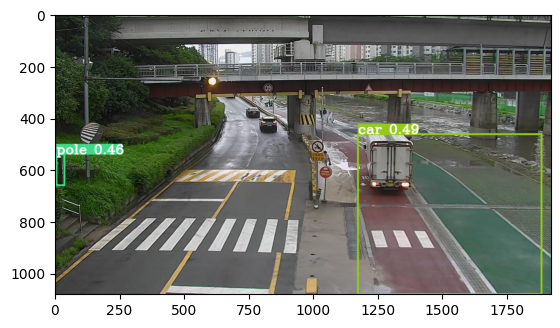

In [214]:
'''
ROI 3: YOLO로 자동차 탐지 후 바운딩박스 생성

변수
unique_boxes: 바운딩 박스 좌표를 중복 저장하지 않기 위해 사용하는 set
class_id: 자동차의 class_id = 6
corners: YOLO 로 탐지한 bounding box의, 네 꼭짓점의 좌표

동작 과정
1. YOLO 로 첫번째 이미지 프레임에 있는 자동차 detect
2. 탐지 결과를 file_path 와 result_image_path 에 저장
3. 탐지 결과를 읽어들인 후, 조건에 맞는 객체 (자동차이며 신뢰도가 0.4 이상) 의 네 꼭짓점의 좌표 출력
4. 탐지 결과 이미지 보여줌
'''

# YOLO detection 관련 경로 설정
print(os.getcwd())
command = [
    './flood312/Scripts/python.exe', './YOLOv6-main/tools/infer.py',
    '--weights', './YOLOv6-main/runs/1000epochs_exp31_best_ckpt.pt',
    '--source', f'./example/' + location + '/' + str(s) + '.jpg',
    '--yaml', './yolo/dataset.yaml',
    '--device', '0',
    '--save-txt', 
    '--save-dir', f'./test_result_obj/' + location + '/'
]

subprocess.run(command)
print("==============")


# 탐지된 결과를 보여주기
obj_detected_img = cv2.imread(f'test_result_obj/{location}/{s}.jpg', cv2.IMREAD_COLOR)
obj_detected_img = cv2.cvtColor(obj_detected_img, cv2.COLOR_BGR2RGB)

# cv2.imshow('Detected Cars', detected_img)
# cv2.waitKey(0)  # 키 입력을 기다림
# cv2.destroyAllWindows()


plt.imshow(obj_detected_img)
plt.show()

#### 자동차 탐지

> COCO pre-trained YOLOv6lv

In [215]:
'''
ROI 3: YOLO로 자동차 탐지 후 바운딩박스 생성

변수
unique_boxes: 바운딩 박스 좌표를 중복 저장하지 않기 위해 사용하는 set
class_id: 자동차의 class_id = 6
corners: YOLO 로 탐지한 bounding box의, 네 꼭짓점의 좌표

동작 과정
1. YOLO 로 첫번째 이미지 프레임에 있는 자동차 detect
2. 탐지 결과를 file_path 와 result_image_path 에 저장
3. 탐지 결과를 읽어들인 후, 조건에 맞는 객체 (자동차이며 신뢰도가 0.4 이상) 의 네 꼭짓점의 좌표 출력
4. 탐지 결과 이미지 보여줌
'''

# YOLO detection 관련 경로 설정
print(os.getcwd())
command = [
    './flood312/Scripts/python.exe', './YOLOv6-main/tools/infer.py',
    '--weights', './YOLOv6-main/runs/yolov6l6.pt',
    '--source', f'./example/' + location + '/' + str(f) + '.jpg',
    '--yaml', './YOLOv6-main/data/coco.yaml',
    '--device', '0',
    '--save-txt', 
    '--save-dir', f'./test_result_car/' + location + '/'
]

subprocess.run(command)
print("==============")

file_path = f'./test_result_car/{location}/labels/{f}.txt'
result_image_path = f'./test_result_car/{location}/{f}.jpg'
result = []

with open(file_path, 'r') as file:
    for line in file:
        elements = line.strip().split()
        int_elements = list(map(float, elements))
        result.append(int_elements)

# 중복된 바운딩 박스 좌표를 저장하지 않도록 set 사용
unique_boxes = set()

cropped_car_images = []

# 바운딩 박스의 좌표 계산 및 출력
img_height, img_width = img_n_org.shape[:2]
for line in result:
    class_id = line[0]
    confidence = line[5]
    if class_id == 2 and confidence >= 0.55:
        # YOLO 형식: class, x_center, y_center, width, height, confidence
        x_center, y_center, width, height = line[1:5]

        # 이미지 좌표계로 변환
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # 바운딩 박스 좌표 (x_min, y_min, x_max, y_max)
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # 네 꼭짓점 좌표
        corners = ((x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max))

        # 중복되지 않은 바운딩 박스 좌표만 추가
        if corners not in unique_boxes:
            unique_boxes.add(corners)
            # 좌표 출력
            print(f"Car detected with bounding box corners: {corners}")

            # 바운딩 박스 영역을 이미지에서 크롭
            cropped_img = img_n_org[y_min:y_max, x_min:x_max]
            
            # 크롭된 이미지 저장
            cropped_car_images.append(cropped_img)

# 탐지된 결과를 보여주기
detected_img = cv2.imread(f'test_result_car/{location}/{f}.jpg', cv2.IMREAD_COLOR)
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
# cv2.imshow('Detected Cars', detected_img)
# cv2.waitKey(0)  # 키 입력을 기다림
# cv2.destroyAllWindows()


plt.imshow(detected_img)
plt.show()

c:\2024\Flooding\flooding


FileNotFoundError: [Errno 2] No such file or directory: './test_result_car/SB/labels/4.txt'

### SAM

> model load

In [169]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt  # matplotlib을 사용하기 위해 추가합니다

sys.path.append("./segment-anything")
from segment_anything import sam_model_registry, SamPredictor

# GPU가 사용 가능한지 확인하고 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device() if torch.cuda.is_available() else "N/A")
print('Count of using GPUs:', torch.cuda.device_count() if torch.cuda.is_available() else 0)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

# SAM 모델 체크포인트 경로 및 타입 설정
sam_checkpoint = "./sam_vit_h_4b8939.pth"
model_type = "vit_h"

# 모델 로드
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Predictor 객체 생성
predictor = SamPredictor(sam)


Device: cpu
Current cuda device: N/A
Count of using GPUs: 0


c:\2024\Flooding\flooding\segment-anything\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


> water segmentation 수행 후 water mask 저장

In [170]:
input1 = img_1_org
input2 = img_n_org
image1 = cv2.cvtColor(input1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(input2, cv2.COLOR_BGR2RGB)
input_point = np.array([seg_cor_1])
input_label = np.array([1])


predictor.set_image(image1)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

img_1_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환


predictor.set_image(image2)
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
img_n_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환

### Module#1 반환 값

- std_cor # 기준점 좌표 (리스트)
- ROI_cor # 물 웅덩이 roi 2개의 좌표 (리스트)
- cal_har_result # 도로폭 환산비율 (실수)
- road_ratio_har_result # 자동차 환산비율 평균 (실수)
- obj_result # 탐지 물체 환산비율 평균 "임의" (실수)


- img_1_org # 원본 첫 프레임 이미지
- img_n_org # 원본 n 프레임 이미지
- img_1_copy2 # 각 점들 및 ROI 표현된 이미지
- img_1_mask # 첫 프레임 mask 이미지
- img_n_mask # n 프레임 mask 이미지

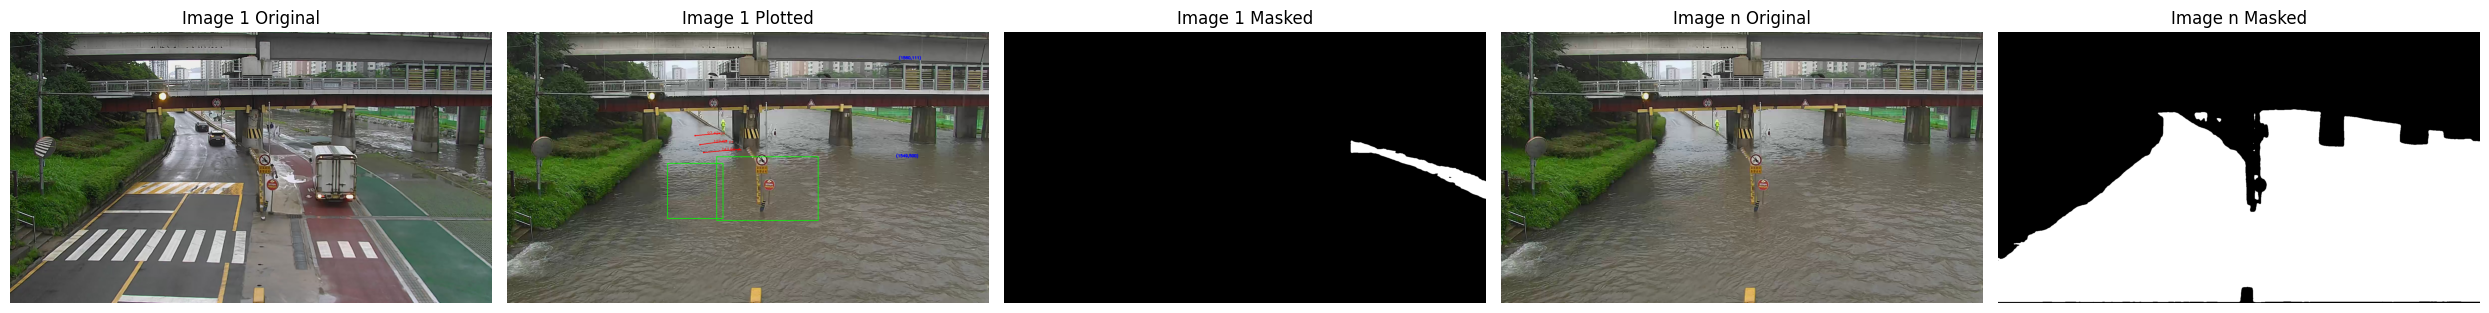

[1560, 111] [(835, 499), (1239, 499), (835, 752), (1239, 752), (639, 525), (860, 525), (639, 744), (860, 744)] 2.6570376282870503 [1.5] [1.5]


In [178]:
# 이 코드는 보여주기 용이라 아래 '~_show' 변수 이미지는 무시해도 됨

img_1_org_show = cv2.cvtColor(img_1_org, cv2.COLOR_BGR2RGB)
img_n_org_show = cv2.cvtColor(img_n_org, cv2.COLOR_BGR2RGB)
img_1_copy2_show = cv2.cvtColor(img_n_copy2, cv2.COLOR_BGR2RGB)


fig, axes = plt.subplots(1, 5, figsize=(25, 5))

axes[0].imshow(img_1_org_show)
axes[0].axis('off')
axes[0].set_title('Image 1 Original')

axes[1].imshow(img_1_copy2_show)
axes[1].axis('off')
axes[1].set_title('Image 1 Plotted')

axes[2].imshow(img_1_mask, cmap = 'gray')
axes[2].axis('off')
axes[2].set_title('Image 1 Masked')

axes[3].imshow(img_n_org_show)
axes[3].axis('off')
axes[3].set_title('Image n Original')

axes[4].imshow(img_n_mask, cmap = 'gray')
axes[4].axis('off')
axes[4].set_title('Image n Masked')

plt.tight_layout()
plt.show()

print(std_cor, ROI_cor, road_ratio_har_result, car_result, obj_result)

# Module #2. 기준점-based

In [253]:
# total_px_dis = []        # 물의 증가값 list (PX)
total_ratio_road = road_ratio_har_result    # 도로 폭 기반 비율값 list (cm/px)
total_ratio_obj = []     # yolo 로 탐지된 기준객체 전체 기준객체 비율 평균값 (cm/px)
module2_results = []    # module #2 추정 침수 레벨 list (level)

### 기준점 (1개) 기반 침수 높이 추정

> 기준객체 기반 비율 계산 (cm/px)

!!!!!!!!!! 신뢰도 0.5 이상으로 수정할 것!!!! (현재는 테스트를 위해 낮게 설정함)

In [254]:
# YOLO 사용한 기준객체 비율 계산
obj_ratio_result = []  # 각 사진 별 기준객체 픽셀 수 계산 리스트


# 위에서 YOLO detection 결과를 저장한 path
file_path = f'test_result_obj/{location}/labels/{s}.txt'

obj_detect_result = []


# YOLO detect 한 바운딩박스 값이 저장된 txt 파일 open
if os.path.isfile(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            # 각 줄의 양 끝 공백을 제거하고, 띄어쓰기를 기준으로 분할하여 리스트로 저장
            elements = line.strip().split()
            int_elements = list(map(float, elements))
            obj_detect_result.append(int_elements)

    # line 의 index 0: 기준객체의 클래스 number
    # line 의 index 5: 기준객체 탐지 신뢰도
    # line 의 index 4: 탐지된 기준객체의 height 값 (px)
    for line in obj_detect_result:
        print(line)
        if line[0] == 0 and line[5] >= 0.3:  # 교각 and 신뢰도 0.3 이상의 detection만
            # 교각 평균 높이.................................... -> 2m
            obj_ratio_result.append( 200 / (img_height * line[4]))
        if line[0] == 1 and line[5] >= 0.3:  # 가로등 and 신뢰도 0.3 이상의 detection만
            # 가로등 평균 높이.................................... -> 4.m
            obj_ratio_result.append( 400 / (img_height * line[4]))
        if line[0] == 6 and line[5] >= 0.3:  # 자동차 and 신뢰도 0.3 이상의 detection만
            # 자동차 평균 높이.................................... -> 1.5m
            obj_ratio_result.append( 150 / (img_height * line[4]))
        if line[0] == 7 and line[5] >= 0.3:  # 전봇대 and 신뢰도 0.3 이상의 detection만
            # 전봇대 평균 높이.................................... -> 14m
            obj_ratio_result.append( 1400 / (img_height * line[4]))
    # print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    # print(obj_ratio_result)

else:
    print("참고할 기준객체가 없습니다.")

print("obj_ratio_result:", obj_ratio_result)

# yolo 로 탐지된 기준객체 기반 비율 계산 (cm/px)
obj_ratio_result = np.array(obj_ratio_result)
# total_ratio_obj.append(len(obj_ratio_result) / np.sum(1.0 / obj_ratio_result) if len(obj_ratio_result) > 0 else 0)  # 조화 평균 사용

total_ratio_obj = np.mean(obj_ratio_result) # 평균내기
print("total_ratio_obj: ", total_ratio_obj)

[7.0, 0.0106771, 0.556019, 0.0161458, 0.110185, 0.457182]
[6.0, 0.79401, 0.714352, 0.369271, 0.571296, 0.486228]
obj_ratio_result: [12.408109089258973, 0.256407142707108]
total_ratio_obj:  6.3322581159830404


> 기준점과 water mask 간의 거리(px) 계산 함수

In [255]:
def find_white_point(img, x, y_start):
    """
    이미지에서 특정 x 좌표에 대해 y_start부터 내려가며 흰색(255) 부분을 찾는 함수
    img: 이미지 (numpy 배열)
    x: 수직선을 그릴 x 좌표
    y_start: 검색을 시작할 y 좌표
    return: 처음으로 흰색(255) 부분과 만나는 (x, y) 좌표
    """
    height = img.shape[0]  # 이미지의 세로 길이 (y 축의 최대 값)

    # y_start부터 이미지의 끝까지 내려가면서 흰색 부분(255)이 있는지 확인
    for y in range(y_start, height):
        if img[y, x] == 255:  # 흰색 부분을 만나면
            return (x, y)

    # 흰색 부분을 만나지 못하면 None 리턴
    return None

#### 사용자 지정 기준점(1개) 기반 침수 레벨 추정

In [256]:
# std_cor 리스트에 있는 각 좌표에 대해 img1과 img2에서 흰색 좌표를 찾기
point_img1 = []
point_img2 = []


x, y_start = std_cor  # std_cor에서 x와 시작 y 좌표를 추출
print(x, y_start)

# img1에서 흰색 부분 찾기
point1 = find_white_point(img_1_mask, x, y_start)
if point1:
    point_img1.append(point1[0])
    point_img1.append(point1[1])

# img2에서 흰색 부분 찾기
point2 = find_white_point(img_n_mask, x, y_start)
if point2:
    point_img2.append(point2[0])
    point_img2.append(point2[1])

# 결과: point_img1, point_img2 에 각각 흰색 좌표들이 저장됨
print("mask 1 에서 물과 맞닿는 좌표:", point_img1)
print("mask n 에서 물과 맞닿는 좌표:", point_img2)

# mask 에서 물의 증가 거리 구하기 (px)
point_water_dis = point_img1[1]-point_img2[1]
print("물의 증가 px:", point_water_dis)

1560 111
mask 1 에서 물과 맞닿는 좌표: [1560, 477]
mask n 에서 물과 맞닿는 좌표: [1560, 364]
물의 증가 px: 113


> 코드 완성되면 삭제할 것

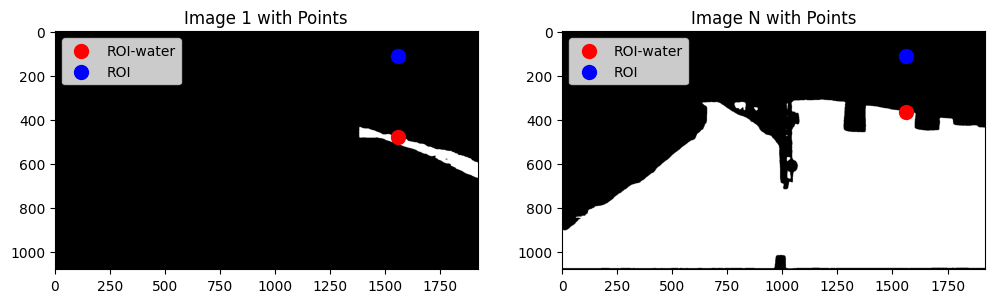

In [257]:
# 이미지 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 이미지 시각화
ax[0].imshow(img_1_mask, cmap='gray')
ax[0].scatter(point_img1[0], point_img1[1], color='red', label='ROI-water', s=100)
ax[0].scatter(x, y_start, color='blue', label='ROI', s=100)
ax[0].set_title('Image 1 with Points')
ax[0].legend()

# 두 번째 이미지 시각화
ax[1].imshow(img_n_mask, cmap='gray')
ax[1].scatter(point_img2[0], point_img2[1], color='red', label='ROI-water', s=100)
ax[1].scatter(x, y_start, color='blue', label='ROI', s=100)
ax[1].set_title('Image N with Points')
ax[1].legend()

plt.show()

In [258]:
one_point = []

one_point.append(point_water_dis*total_ratio_road) # 도로 폭 비율 곱함
one_point.append(point_water_dis*total_ratio_obj) # 기준객체 비율 곱함

print(one_point)
print("도로 폭 기반 침수 깊이 (cm): ", one_point[0])
print("기준객체 기반 침수 깊이 (cm): ", one_point[1])


# 가중치 계산
# 도로 폭 가중치: 3
# 기준객체 가중치: 1
module2_results.append((one_point[0] * 3 + one_point[1]* 1 ) / 4)
print(module2_results)

[np.float64(300.2452519964367), np.float64(715.5451671060836)]
도로 폭 기반 침수 깊이 (cm):  300.2452519964367
기준객체 기반 침수 깊이 (cm):  715.5451671060836
[np.float64(404.0702307738484)]


In [259]:
module2_results

[np.float64(404.0702307738484)]

#### 사용자 지정 기준점(1개) + 그 주변 점(2개) 기반 침수 레벨 추정

In [260]:
# 직접 찍은 기준점과 그 근처 점(2개) -  물 사이의 거리 구하기

# std_cor 리스트에 있는 각 좌표에 대해 img1과 img2에서 흰색 좌표를 찾기
point_img1 = []
point_img2 = []


x, y_start = std_cor  # std_cor에서 x와 시작 y 좌표를 추출
print(x, y_start)

for i in range(3):
    # img1에서 흰색 부분 찾기
    point1 = find_white_point(img_1_mask, x, y_start)
    if point1:
        point_img1.append(point1[0])
        point_img1.append(point1[1])

    # img2에서 흰색 부분 찾기
    point2 = find_white_point(img_n_mask, x, y_start)
    if point2:
        point_img2.append(point2[0])
        point_img2.append(point2[1])
    x += 60


# 결과: point_img1, point_img2 에 각각 흰색 좌표들이 저장됨
print("mask 1 에서 물과 맞닿는 좌표:", point_img1)
print("mask n 에서 물과 맞닿는 좌표:", point_img2)



1560 111
mask 1 에서 물과 맞닿는 좌표: [1560, 477, 1620, 502, 1680, 516]
mask n 에서 물과 맞닿는 좌표: [1560, 364, 1620, 447, 1680, 451]


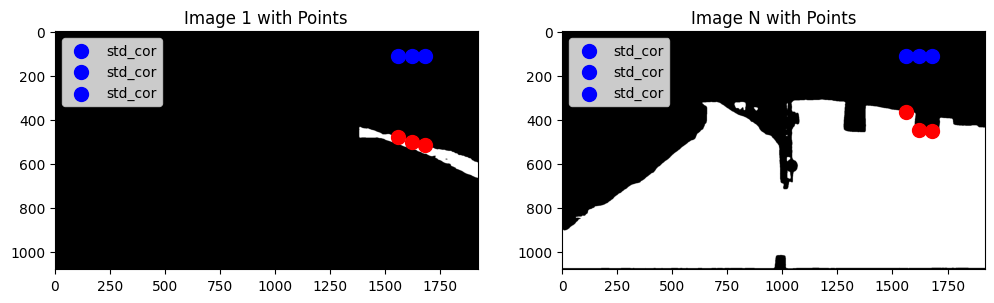

In [261]:
# 이미지 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 이미지 시각화
ax[0].imshow(img_1_mask, cmap='gray')

x = std_cor[0]
# point_img1 시각화
for i in range(0, len(point_img1), 2):  # 2씩 증가하며 점을 묶어 시각화
    ax[0].scatter(point_img1[i], point_img1[i + 1], color='red', s=100)
    # std_cor 시각화 (이동한 위치)
    ax[0].scatter(x, std_cor[1] , color='blue', label='std_cor', s=100)
    x += 60
ax[0].set_title('Image 1 with Points')
ax[0].legend()

# 두 번째 이미지 시각화
ax[1].imshow(img_n_mask, cmap='gray')

x = std_cor[0]
# point_img2 시각화
for i in range(0, len(point_img2), 2):  # 2씩 증가하며 점을 묶어 시각화
    ax[1].scatter(point_img2[i], point_img2[i + 1], color='red', s=100)
    # std_cor 시각화 (이동한 위치)
    ax[1].scatter(x, std_cor[1], color='blue', label='std_cor', s=100)
    x += 60
ax[1].set_title('Image N with Points')
ax[1].legend()

plt.show()

In [262]:
total_ratio_obj

np.float64(6.3322581159830404)

In [263]:
from statistics import mean
point_water_dis=[]
three_point_road = []
three_point_obj = []

for i in range(3):
    # mask 에서 물의 증가 거리 구하기 (px)
    point_water_dis.append(point_img1[i*2+1]-point_img2[i*2+1])

    # 위에서 구한 도로 폭 & 기준객체 비율 곱하면 끝임
    three_point_road.append(point_water_dis[i]*total_ratio_road) # 도로 폭 비율 곱함
    three_point_obj.append(point_water_dis[i]*total_ratio_obj) # 기준객체 비율 곱함



print("물의 증가 px:", point_water_dis)
print("도로 폭 기반 침수 깊이 (cm): ", mean(three_point_road))
print("기준객체 기반 침수 깊이 (cm): ", mean(three_point_obj))


# 가중치 계산
# 도로 폭 가중치: 3
# 기준객체 가중치: 1
module2_results.append((mean(three_point_road) * 3 + mean(three_point_obj)* 1 ) / 4)
print(module2_results)

물의 증가 px: [113, 55, 65]
도로 폭 기반 침수 깊이 (cm):  206.3632557969609
기준객체 기반 침수 깊이 (cm):  491.80538034134946
[np.float64(404.0702307738484), np.float64(277.7237869330581)]


마스크 전체 조화평균 기반

In [264]:
# 이미지 경로 확인 및 로드
img_1_array = np.array(img_1_mask)
img_n_array = np.array(img_n_mask)

mask_height, mask_width, = img_1_array.shape
height = []
x_array = []

# 침수 비교 영역 설정
for x in range(mask_width):
    for y in range(mask_height):
        if img_n_array[y, x] > 200:  # 침수 후 영역의 x 값이
            if img_1_array[y, x] > 200:  # 침수 전 영역의 x 값에도 있다면
                x_array.append(x)  # 올바른 침수 비교 영역으로 설정
                break

print(f"Valid X coordinates count: {len(x_array)}")

# y 값의 증가 값 계산
for x in x_array:
    for y in range(mask_height):
        if img_1_array[y, x] > 200:
            a = y  # 침수 비교 영역의 x값에 대한 가장 높은 침수 전 영역의 y 값
            break
    for y in range(mask_height):
        if img_n_array[y, x] > 200:
            b = y  # 침수 비교 영역의 x값에 대한 가장 높은 침수 후 영역의 y 값
            break
    height.append(a - b)  # y 값의 증가 값

height = np.array(height)

# 조화 평균 계산
if len(height) > 0 and np.sum(height > 0) > 0:  # 0으로 나누는 경우 방지
    harmonic_height_mask = len(height) / np.sum(1.0 / height[height > 0])
    print(f"Mask's Harmonic Flood Height(px): {harmonic_height_mask}")
else:
    harmonic_height_mask = 0
    print("No valid height data for harmonic mean calculation.")

Valid X coordinates count: 539
Mask's Harmonic Flood Height(px): 101.08632509147182


In [265]:
har_total = []

# 위에서 구한 도로 폭 & 기준객체 비율 곱하면 끝임
har_total.append(harmonic_height_mask*total_ratio_road) # 도로 폭 비율 곱함
har_total.append(harmonic_height_mask*total_ratio_obj) # 기준객체 비율 곱함


print("물의 증가 px:", harmonic_height_mask)
print("도로 폭 기반 침수 깊이 (cm): ", har_total[0])
print("기준객체 기반 침수 깊이 (cm): ", har_total[1])


# 가중치 계산
# 도로 폭 가중치: 3
# 기준객체 가중치: 1
module2_results.append((har_total[0] * 3 + har_total[1]* 1 ) / 4)
print(module2_results)

물의 증가 px: 101.08632509147182
도로 폭 기반 침수 깊이 (cm):  268.59016947329803
기준객체 기반 침수 깊이 (cm):  640.1047024753725
[np.float64(404.0702307738484), np.float64(277.7237869330581), np.float64(361.4688027238167)]


> mask 시각화

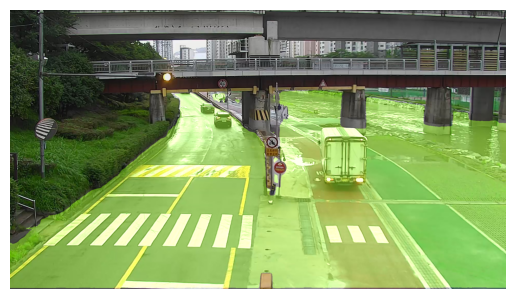

In [266]:
# 보라색 색상 정의 (BGR)
purple_color = (0, 100, 55)

# mask 이미지를 보라색으로 변환하고, 검정색 부분을 투명하게 만든다
purple_mask = np.zeros_like(img_1_org)
purple_mask[img_n_mask > 0] = purple_color

# 알파 채널 추가 (투명도 설정)
alpha_channel = np.zeros_like(img_n_mask)
alpha_channel[img_n_mask > 0] = 255
purple_mask = cv2.merge((*cv2.split(purple_mask), alpha_channel))

# 원본 이미지에도 알파 채널 추가
original_image = cv2.cvtColor(img_1_org, cv2.COLOR_BGR2BGRA)

# 두 이미지를 합친다
combined_image = cv2.addWeighted(original_image, 1, purple_mask, 1, 0)

# 결과 이미지를 plt로 보여준다
plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGRA2RGBA))  # BGR에서 RGBA로 변환
plt.axis('off')  # 축을 끄기
plt.show()  # 결과를 보여준다


In [267]:
# 도로 폭 / 기준객체 기반 침수 추정 값에 가중치 계산

In [268]:
module2_results

[np.float64(404.0702307738484),
 np.float64(277.7237869330581),
 np.float64(361.4688027238167)]

In [269]:
# 계산된 값(cm) 에 대한 레벨 산정하는 코드

module2_results_level = []

# cm -> level 변환 (임의)
# 0 -> level 0
# 1 ~ 50 -> level 1
# 51 ~ 100 -> level 2
# 101 ~ 200 -> level 3
# 201 ~ -> level 4
for i in range(len(module2_results)):
    if module2_results[i] == 0:
        module2_results_level.append(0)
    elif 1 <= module2_results[i] <= 50:
        module2_results_level.append(1)
    elif 51 <= module2_results[i] <= 100:
        module2_results_level.append(2)
    elif 101 <= module2_results[i] <= 200:
        module2_results_level.append(3)
    elif 201 <= module2_results[i]:
        module2_results_level.append(4)

# 각 방법 별 가중치 두기 위해 순서 바꿈
module2_results_level.reverse()

print("Module#2 기준점-based 결과")
print("침수 추정 레벨: ", module2_results_level)

Module#2 기준점-based 결과
침수 추정 레벨: module2_results_level


# Module#3 woong-based

In [30]:
ROI_cor

[(933, 514),
 (1310, 514),
 (933, 804),
 (1310, 804),
 (577, 470),
 (919, 470),
 (577, 707),
 (919, 707)]

level: 2
level: 2


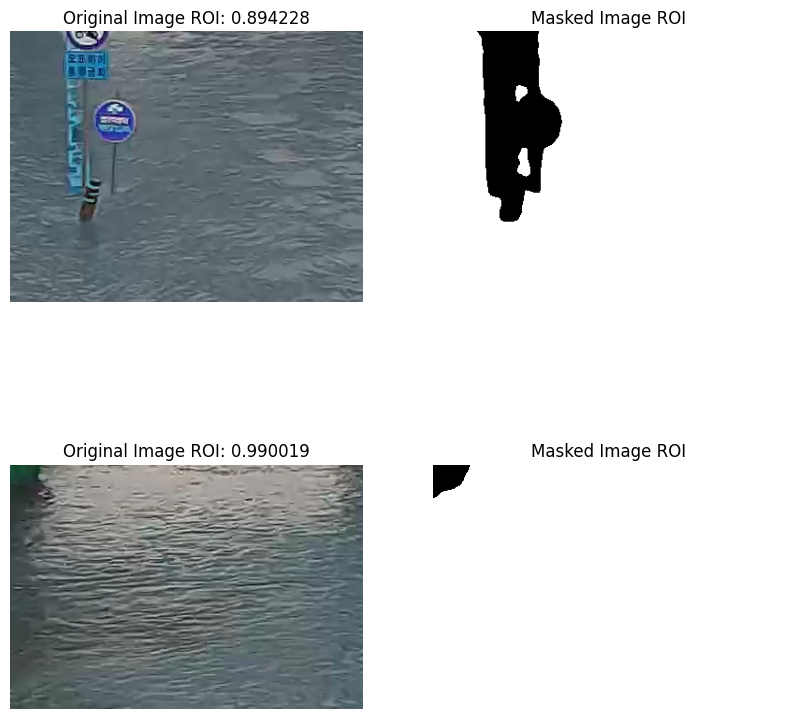

In [32]:
img_n_mask = (masks[1] * 255).astype(np.uint8)  # 마스크를 0-255 범위로 변환
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    roi = img_n_mask[ROI_cor[(i*4+0)][1]:ROI_cor[(i*4+2)][1], ROI_cor[(i*4+0)][0]:ROI_cor[(i*4+1)][0]]
    roi_ori = img_n_org[ROI_cor[(i*4+0)][1]:ROI_cor[(i*4+2)][1], ROI_cor[(i*4+0)][0]:ROI_cor[(i*4+1)][0]]
    percentage = (np.sum(roi)/255)/((ROI_cor[i*4][0]-ROI_cor[i*4+1][0])*(ROI_cor[i*4][1]-ROI_cor[i*4+2][1]))
    axes[i][0].imshow(roi_ori)
    axes[i][0].axis('off')
    axes[i][0].set_title(f'Original Image ROI: {percentage:f}')

    axes[i][1].imshow(roi, cmap='gray')
    axes[i][1].axis('off')
    axes[i][1].set_title('Masked Image ROI')



    if percentage > 0.5:
        print('level: 2')
    elif percentage > 0:
        print('level: 1')
    else:
        print('level: 0')

plt.show()




# Module#4. car-based method

In [33]:
# Device 설정 (GPU가 있으면 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize((125, 125)),
    transforms.ToTensor()
])

# VGG16 모델 초기화
model = models.vgg16()

# 마지막 레이어를 3개의 클래스를 예측하도록 수정
model.classifier[6] = torch.nn.Linear(4096, 3)

# 모델을 GPU 또는 CPU로 전송
model = model.to(device)

checkpoint_path = './vgg16_final_weights.pth'  # 저장된 체크포인트 파일 경로
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint)  # 체크포인트에서 가중치 로드
    model.eval()
else:
    print("Checkpoint 파일을 찾을 수 없습니다.")
    exit()

# 이미지 배열 전처리
def preprocess_image(cropped_img):
    img_pil = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess(img_pil)
    img_tensor = img_tensor.unsqueeze(0).to(device)  # 배치 차원 추가 및 디바이스로 이동
    return img_tensor

predicted_class=[]
# YOLO를 통해 탐지된 자동차 이미지에 대해 VGG16 모델 예측 
def predict_vgg16(model, cropped_car_images):
    class_names = ['0', '1', '2']  # 예시 클래스 이름 (필요 시 수정)
    for idx, cropped_img in enumerate(cropped_car_images):
        if cropped_img is not None and cropped_img.size > 0:
            img_tensor = preprocess_image(cropped_img)
            with torch.no_grad():
                output = model(img_tensor)
                _, predicted = torch.max(output, 1)
                predicted_class.append(class_names[predicted.item()])
                print(f"Predicted class for Cropped Car {idx + 1} :{predicted_class[idx]}")
        else:
            print(f"Warning: Cropped Car {idx + 1} is None or empty")

# YOLO로 탐지된 자동차 이미지 리스트(cropped_car_images)를 VGGNet에 입력하여 예측 실행
predict_vgg16(model, cropped_car_images)

C:\Users\th_gu\AppData\Local\Temp\ipykernel_15812\2958385987.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

NameError: name 'cropped_car_images' is not defined

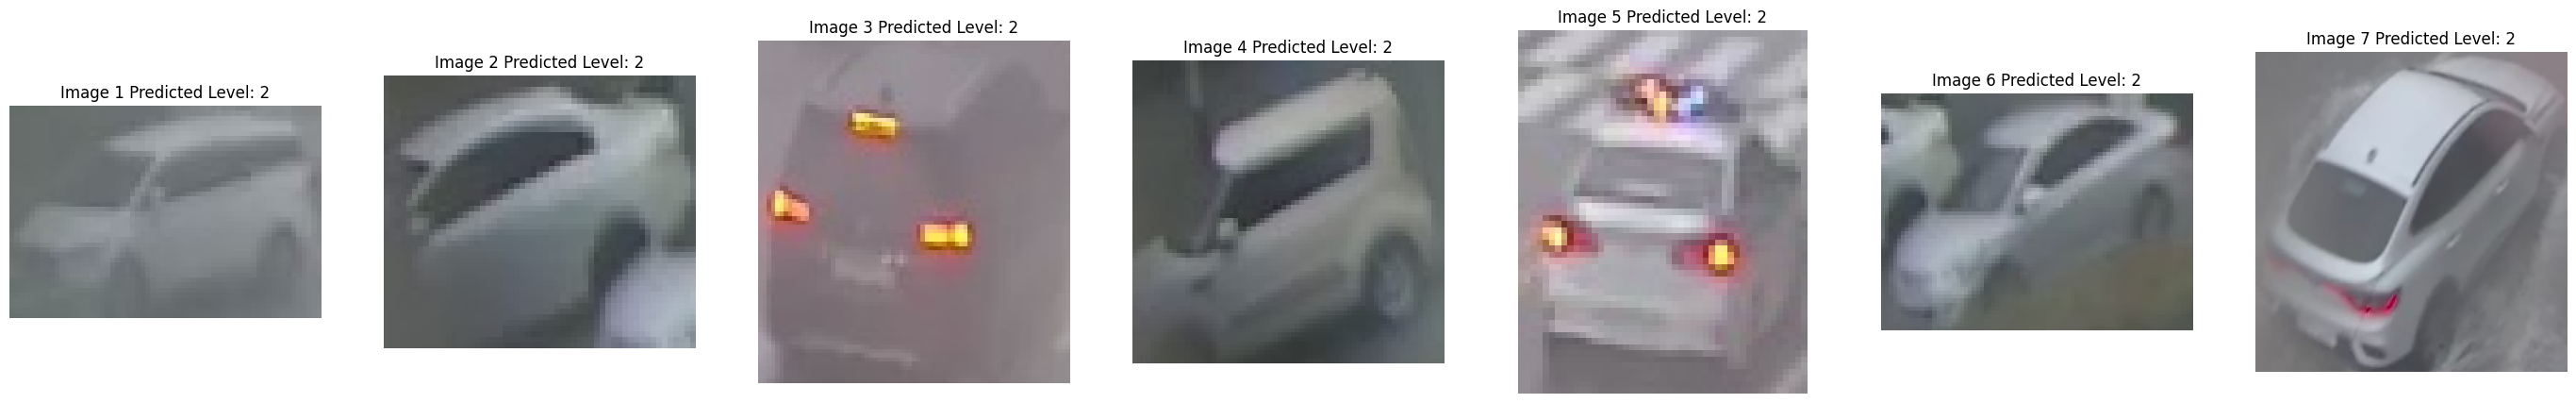

In [59]:

cropped_car_count = len(cropped_car_images)
fig, axes = plt.subplots(1, cropped_car_count, figsize=((cropped_car_count*5), 5))

for i in range(cropped_car_count):
    # 이미지가 제대로 크롭되었는지 확인 후 표시
    cropped_car_images[i] = cv2.cvtColor(cropped_car_images[i], cv2.COLOR_BGR2RGB)
    if cropped_img is not None and cropped_img.size > 0:
        axes[i].imshow(cropped_car_images[i])
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1} Predicted Level: {predicted_class[i]}')
    else:
        print(f"Warning: Cropped Car is None or empty")